In [1]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# 一、分子指纹提取

## 1.Topological Fingerprints
也叫RDKit topological fingerprint。该算法受[Daylight fingerprint](https://www.daylight.com/dayhtml/doc/theory/theory.finger.html)启发而产生,它会计算所有介于minPath和maxPath之间的分子路径（子图，subgraphs），对每个子图进行哈希运算，产生一个原始的bit ID。对bit ID取模（除数是fpSize），并在相应的位上进行设置。
对子图做哈希运算，其实就是对原子和键做哈希，它考虑了原子类型、芳香性、键的类型三种特征

对每个子图生成指纹的大致流程：
- 对子图计算一个哈希值
- 使用哈希值生成一个raw ID
- 对raw ID取模
- 如果nBitsPerHash大于1，根据raw ID再随机生成一个数，直到达到指定值（为什么这么做，我猜可能是避免bit collision的问题吧）
- 组成分子指纹相应的位。

rdkit提取拓扑分子指纹
* 计算拓扑分子指纹：RDKFingerprint(mol, minPath，maxPath, fpSize, nBitsPerHash, useHs, tgtDensity, bitInfo, ...)<br />
mol：mol对象<br />
minPath：默认1。生成子图所需的最少键的数量<br />
maxPath：默认7。生成子图时最多键的数量<br />
fpSize：生成指纹的长度，默认2048<br />
nBitsPerHash：默认2。每个子图对应的位数。如果大于1，就将raw ID作为种子随机生成若干个数。<br />
useHs：默认True，将显式氢考虑进指纹中。<br />
tgtDensity：默认0。如果大于0，指纹长度会不断减半，直到大于等于设置的密度，或到达minSize的设置值。<br />
bitInfo：用于接收指纹结果的字典。键为位数，值为相同指纹的列表(列表的每个元素为键的序号)。<br />

In [2]:
ms = [Chem.MolFromSmiles('CCOC'), Chem.MolFromSmiles('CCO'), Chem.MolFromSmiles('COC')]
fps = [Chem.RDKFingerprint(x) for x in ms]
fps

* 相似度比较：DataStructs.FingerprintSimilarity(fp1, fp2)

In [3]:
DataStructs.FingerprintSimilarity(fps[0], fps[1])

0.6

* 通过传入空字典rdkinfo获取非空分子指纹信息<br />
字典info键表示位的索引，值为一个列表。列表中的每个元素都是组成该子图的键<br />
黄色表示带有芳香性质的原子

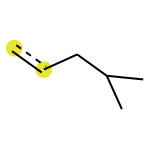

In [4]:
mol = Chem.MolFromSmiles('c1ccccc1CC1CC1')
rdkinfo = {}
rdkfp = Chem.RDKFingerprint(mol, bitInfo=rdkinfo)
img = Draw.DrawRDKitBit(mol, list(rdkinfo.keys())[0], rdkinfo)
img

In [5]:
img.save('data/fp_and_simi_1.png')

## 2.MACCS
是一种基于SMARTS的，长度为167的分子指纹，每一位所代表的含义可以[参考这里](https://github.com/openbabel/openbabel/blob/master/data/MACCS.txt)。

In [6]:
from rdkit.Chem import MACCSkeys
fps = [MACCSkeys.GenMACCSKeys(x) for x in ms]
DataStructs.FingerprintSimilarity(fps[0],fps[1])

0.5

In [7]:
fps[0].GetNumBits()

167

## 3.Atom Pairs and Topological Torsions
这两种指纹算法的概念在30多年前提出，比较相似，指纹会包括原子序号、π电子数和相邻原子数三个维度的信息。此外还可以通过参数，加入手性的信息。两种指纹都可以用sparse form和explicit form形式来表示，并且可以查看指纹所代表的化学信息。
* 计算atom pair指纹：GetAtomPairFingerprint(mol, minLength, maxLength, ...)
* 同GetAtomPairFingerprintAsIntVect()<br />
这个方法生成的指纹非常庞大稀疏。

In [8]:
from rdkit.Chem.AtomPairs import Pairs
fps = [Pairs.GetAtomPairFingerprint(x) for x in ms]

* 可以通过该方法获取atom pairs算法产生的非空元素：GetNonzeroElements()<br />
返回值是一个字典，键为指纹所在的位，值为出现的频数。

In [9]:
fps[2].GetNonzeroElements()

{541730: 1, 1606689: 2}

* 也可以查看位所代表的指纹：Pairs.ExplainPairScore()

In [10]:
Pairs.ExplainPairScore(1606689)

(('C', 1, 0), 1, ('O', 2, 0))

该结果表示这样一种子结构：有1个相邻原子和0个π电子的碳原子，通过一个键，与有2个相邻原子和0个π电子的氧原子相连。

* 也可以用一个定长向量来表示atom pair：GetAtomPairFingerprintAsBitVect()<br />
注意：该方法不会记录子结构的频数，只用0和1表示是否存在。

In [11]:
pairFps = [Pairs.GetAtomPairFingerprintAsBitVect(x) for x in ms]
pairFps[0].GetNumBits()

8388608

In [12]:
DataStructs.DiceSimilarity(pairFps[0],pairFps[1])

0.2222222222222222

* 生成Topological Torsion指纹：GetTopologicalTorsionFingerprint(mol, targetSize, ...)
* 同GetTopologicalTorsionFingerprintAsIntVect()<br />
mol：mol对象<br />
targetSize：子图的长度<br />

In [13]:
from rdkit.Chem.AtomPairs import Torsions
ttfp = Torsions.GetTopologicalTorsionFingerprintAsIntVect(ms[0])

* 获取非空元素：GetNonzeroElements()
* 查看位所代表的指纹：ExplainPairScore()

In [14]:
ttfp.GetNonzeroElements()

{4320149536: 1}

In [15]:
Torsions.ExplainPathScore(4320149536)

(('C', 1, 0), ('C', 2, 0), ('O', 2, 0), ('C', 1, 0))

## 4.Morgan Fingerprints (Circular Fingerprints)
摩根分子指纹，也成为圆形指纹，是采用摩根算法而产生。使用时，需要提供原子半径。这里只展示最基本的使用方法，更多关于指纹生成、提取与展示的操作可以[参考这篇文章](https://blog.csdn.net/dreadlesss/article/details/105976113)
* 以SparseBitVects方式生成摩根指纹：GetMorganFingerprint(mol, radius)<br />
radius：考虑半径

In [16]:
mfp = [AllChem.GetMorganFingerprint(x, 2) for x in ms]
mfp[0].GetLength()

4294967295

* 查看非空元素：GetNonzeroElements()<br />
这里记录的指纹是包括频数的

In [17]:
mfp[2].GetNonzeroElements()

{864674487: 1, 2154640335: 1, 2246728737: 2, 3975275337: 2}

* 以ExplicitBitVects方式生成摩根指纹：GetMorganFingerprintAsBitVect(mol, radius, nBits)<br />
radius：考虑半径<br />
nBits：指纹长度<br />
这种方法将不再记录频数

In [18]:
mfp = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=10) for x in ms]
print(mfp[0].GetNumBits())
print(mfp[0].ToBitString())
print(DataStructs.DiceSimilarity(mfp[0], mfp[1]))

10
0010100100
0.75


# 二、相似性

## 1.相似性比较
分子指纹的应用之一就是比较分子间相似性。
* 相似度比较：DataStructs.FingerprintSimilarity(fp1, fp2, metric)<br />
fp1, fp2：待比较的分子<br />
metric：距离度量方法，默认为DataStructs.TanimotoSimilarity

In [19]:
ms = [Chem.MolFromSmiles('CCOC'), Chem.MolFromSmiles('CCO')]
fps = [Chem.RDKFingerprint(x) for x in ms]
DataStructs.FingerprintSimilarity(mfp[0], mfp[1])

0.6

* 度量方法非常多，随便举几例：Tanimoto, Dice, Cosine, Sokal, Russel, Kulczynski, McConnaughey等，按需选择。

In [20]:
metic_list = ['DataStructs.TanimotoSimilarity',
              'DataStructs.DiceSimilarity',
              'DataStructs.CosineSimilarity',
              'DataStructs.SokalSimilarity',
              'DataStructs.RusselSimilarity',
              'DataStructs.KulczynskiSimilarity',
              'DataStructs.McConnaugheySimilarity']
for i in metic_list:
    print(DataStructs.FingerprintSimilarity(fps[0], fps[1], metric=eval(i)))

0.6
0.75
0.7745966692414834
0.42857142857142855
0.0029296875
0.8
0.6


* 以上方法也可以直接调用，以Tanimoto为例：DataStructs.TanimotoSimilarity(bv1, bv2)

bv1、bv2：两个分子指纹的bit vetor

In [21]:
DataStructs.TanimotoSimilarity(fps[0], fps[1])

0.6

## 2.相似性地图
相似性地图是一种用来可视化分子中原子相似性程度的方法，具体可以参考rdkit中的rdkit.Chem.Draw.SimilarityMaps模块
* 先来初始化两个分子

In [22]:
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')

相似性地图模块支持三种分子指纹的比较和可视化：atom pairs、topological torsions和Morgan fingerprints。

 - 使用atom pairs和topological torsions时，fpType可选值有：normal（默认值）、hashed、bit vector(bv)。
 - 使用morgan指纹时，fpType可选值为：bv（默认值）和count(count vector)
 - 该模块内的分子指纹方法也可以通过AllChem直接调用

In [23]:
from rdkit.Chem.Draw import SimilarityMaps
fp = SimilarityMaps.GetAPFingerprint(mol, fpType='normal')
fp1 = AllChem.GetAtomPairFingerprint(mol)
print(fp == fp1)
fp = SimilarityMaps.GetTTFingerprint(mol, fpType='normal')
fp1 = AllChem.GetTopologicalTorsionFingerprint(mol)
print(fp == fp1)
fp = SimilarityMaps.GetMorganFingerprint(mol, fpType='bv')
fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
print(fp == fp1)

True
True
True


* 生成相似性地图：GetSimilarityMapForFingerprint(refMol, probeMol, fpFunction, metric, ...)<br />
refMol：参照分子<br />
probeMol：探针分子<br />
fpFunction：指定所用的分子指纹方法<br />
metric：相似性度量方法（默认为DataStructs.DiceSimilarity）

In [24]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)

* 对morgan指纹的参数、相似性度量方法进行修改，例如使用半径为1，count模式，并使用Tanimoto系数

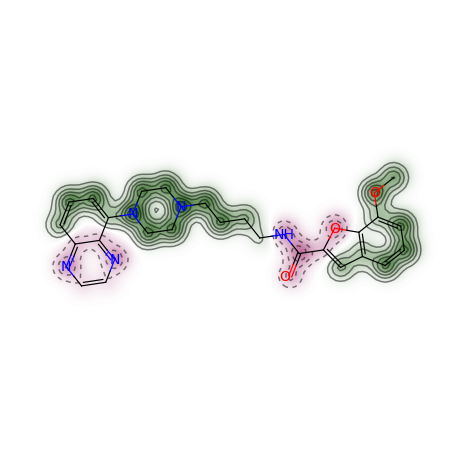

In [25]:
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=1, fpType='count'), metric=DataStructs.TanimotoSimilarity)

GetSimilarityMapForFingerprint包括了对原子权重的标准化，最大的绝对权重为1。因此，当创建了一个相似性地图时，该函数会输出一个最大的权重。

In [26]:
maxweight

0.05747126436781608

如果不想使用标准化步骤，可以通过如下方式创建相似性地图

In [27]:
weights = SimilarityMaps.GetAtomicWeightsForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)
print(["%.2f " % w for w in weights])

['0.05 ', '0.07 ', '0.05 ', '0.08 ', '0.05 ', '0.06 ', '0.03 ', '0.04 ', '-0.01 ', '-0.04 ', '-0.03 ', '-0.05 ', '0.01 ', '0.03 ', '0.07 ', '0.10 ', '0.12 ', '0.11 ', '0.09 ', '0.10 ', '0.09 ', '0.06 ', '0.03 ', '0.02 ', '-0.01 ', '-0.05 ', '0.00 ', '0.00 ', '-0.03 ', '0.02 ', '0.09 ', '0.11 ', '-0.04 ', '0.04 ']


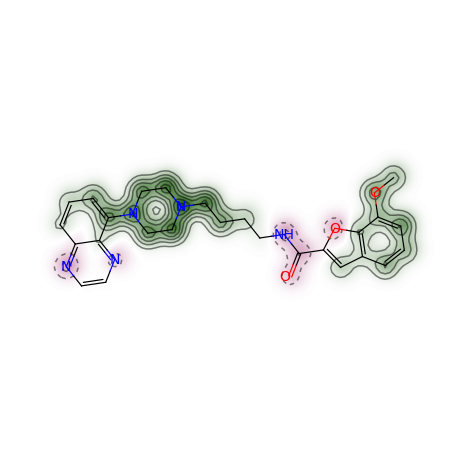

In [28]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, weights)

## 3.相似性应用——构建多样化分子库
有时会遇到这种任务，需要从整个分子库中，挑出一个子集，使子集的多样性最高，或者能最大程度地代表原始分子库的化学空间。Rdkit在rdkit.SimDivFilters模块中提供了一系列的方法用来处理这种需求，最有效的是MaxMin算法，[有文章报道](https://onlinelibrary.wiley.com/doi/epdf/10.1002/qsar.200290002)该方法优于k-means。使用MaxMin算法从N个分子的库中挑选k个分子作为子集的大致流程如下：
 - 1.选择一个种子化合物用于初始化子集，并设置x=1。
 - 2.遍历分子库中剩余的N-x个分子，计算它与子集x中每个分子的相异性（可以认为是“1-相似度”），并取x个相异性值中最小的一个作为最终相异值（该值反应了库中分子与子集中最相似分子的相异性）。
 - 3.选择分子库中最终相异值最大的化合物(MaxMin名称的由来)，将其加入到子集中，并更新x += 1，重复步骤2，直到x==k。

 - 注：步骤2和3也可以看作是，遍历库中的分子，挑选与子集x中最相似的分子，计算相似度值，再从分子库中，选择该相似度值最小的分子，加入子集中。换句话说，也就是某个分子与子集中的分子已经很相似了，但是该相似度还是比其他化合物低，表明该分子与子集中的分子差异比库中其他分子与子集的差异都要大。

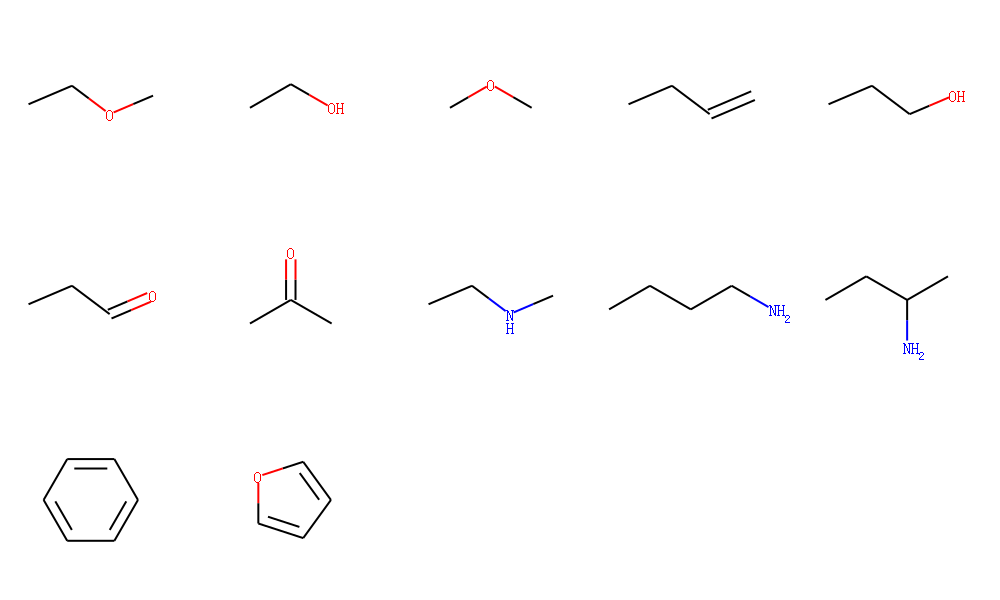

In [29]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
ms = [Chem.MolFromSmiles('CCOC'),
      Chem.MolFromSmiles('CCO'),
      Chem.MolFromSmiles('COC'),
      Chem.MolFromSmiles('CCC=C'),
      Chem.MolFromSmiles('CCCO'),
      Chem.MolFromSmiles('CCC=O'),
      Chem.MolFromSmiles('CC(=O)C'),
      Chem.MolFromSmiles('CCNC'),
      Chem.MolFromSmiles('CCCCN'),
      Chem.MolFromSmiles('CCC(N)C'),
      Chem.MolFromSmiles('c1ccccc1'),
      Chem.MolFromSmiles('c1cocc1'),]
fps = [AllChem.GetMorganFingerprint(x, 2) for x in ms]
img = Draw.MolsToGridImage(ms, molsPerRow=5)
img

In [30]:
img.save('data/fp_and_simi_3.png')

* 该算法需要先定义一种相异性度量方法，用于比较分子间的距离，以DiceSimilarity为例

In [31]:
def distij(i, j, fps=fps):
    return 1-DataStructs.TanimotoSimilarity(fps[i],fps[j])

* 再创建一个picker对象：MaxMinPicker()
* 挑选分子：picker.LazyPick(distFunc, poolSize, pickSize, firstPicks, seed, ...)<br />
distFunc：相似性度量函数，该函数可以接收两个索引，并返回相应的距离。<br />
poolSize：总分子数量<br />
pickSize：要挑出的分子数量<br />
firstPicks：第一个初始化的分子<br />
seed：随机种子

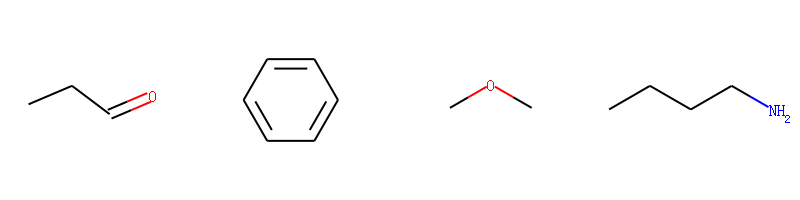

In [32]:
picker = MaxMinPicker()
pickIndices = picker.LazyPick(distij, len(ms), 4, seed=1)
picks = [ms[x] for x in pickIndices]
img = Draw.MolsToGridImage(picks, molsPerRow=4)
img

In [33]:
img.save('data/fp_and_simi_4.png')

* 顺便介绍下k-means基于聚类构建多样性分子库的方法，大致流程如下：
 - 1.初始化k个类别的代表（k为用户提供），并计算类的质心centroids
 - 2.遍历分子库中的每个分子，计算该分子与各个类的代表间的距离，并划分到距离最近的类中
 - 3.更新各个类别的代表，如果类别没有收敛，则重复步骤2
 - 4.从分好的各个类别中，选取若干分子组成最终的子集。